In [2]:
# Cell 1: 导入库和基本设置
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import time
import pandas as pd
import scipy.constants as const
from tqdm import tqdm
import os
import warnings
import json

# Import the PSO implementation
from PSO import (
    crcbqcpsopsd, crcbgenqcsig, normsig4psd, innerprodpsd,
    calculate_matched_filter_snr, pycbc_calculate_match, refine_distance_parameter
)

# Import Bilby for MCMC implementation
import bilby
from bilby.core.likelihood import Likelihood
from bilby.core.prior import Uniform, PriorDict

from pycbc.types import FrequencySeries, TimeSeries
from pycbc.filter import match

# Constants
G = const.G
c = const.c
M_sun = 1.989e30
pc = 3.086e16

# Create results directory
results_dir = "L_Result_new"
os.makedirs(results_dir, exist_ok=True)

# Set plotting parameters
plt.rcParams.update({
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 1.5,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.8
})

print("✓ 所有库导入成功，环境配置完成")

✓ 所有库导入成功，环境配置完成


In [3]:
# Cell 2: 数据加载和参数设置函数

def load_data():
    """Load gravitational wave data for analysis"""
    print("加载引力波数据...")

    TrainingData = scio.loadmat('../generate_data/noise.mat')
    analysisData = scio.loadmat('../generate_data/data.mat')

    print("数据加载成功")

    # Convert data to NumPy arrays
    dataY = np.asarray(analysisData['data'][0])
    training_noise = np.asarray(TrainingData['noise'][0])
    dataY_only_signal = dataY - training_noise

    # Get basic parameters
    Fs = float(analysisData['samples'][0][0])
    dt = 1 / Fs
    t = np.arange(0, 8, dt)

    # Calculate PSD
    psdHigh = np.asarray(TrainingData['psd'][0])

    return {
        't': t,
        'dataY': dataY,
        'dataY_only_signal': dataY_only_signal,
        'noise': training_noise,
        'psdHigh': psdHigh,
        'sampFreq': Fs,
        'nSamples': dataY.size
    }


def setup_parameters(data):
    """Set up parameter ranges for both PSO and MCMC"""

    # Define parameter ranges
    param_ranges = {
        'rmin': np.array([-2, 0, 0.1, 0, 0, 0.1]),
        'rmax': np.array([4, 2, 8.0, np.pi, 1.0, 4.0])
    }

    # Define actual parameters for validation
    actual_params = {
        'chirp_mass': 30.09,
        'merger_time': 7.5,
        'source_distance': 3100.0,
        'flux_ratio': 0.3333,
        'time_delay': 0.9854,
        'phase': 0.25
    }

    # Set up PSO input parameters
    pso_params = {
        'dataX': data['t'],
        'dataY': data['dataY'],
        'dataY_only_signal': data['dataY_only_signal'],
        'sampFreq': data['sampFreq'],
        'psdHigh': data['psdHigh'],
        'rmin': param_ranges['rmin'],
        'rmax': param_ranges['rmax']
    }

    # Set up PSO configuration
    pso_config = {
        'popsize': 50, 
        'maxSteps': 2000,  
        'c1': 2.0,
        'c2': 2.0,
        'w_start': 0.9,
        'w_end': 0.5,
        'max_velocity': 0.4,
        'nbrhdSz': 6,
        'disable_early_stop': False  # Enable early stopping
    }

    return param_ranges, pso_params, pso_config, actual_params

print("✓ 数据加载和参数设置函数定义完成")

✓ 数据加载和参数设置函数定义完成


In [4]:
# Cell 3: 似然函数类定义

class GWLikelihood(Likelihood):
    """Gravitational wave likelihood function for Bilby"""

    def __init__(self, data_dict):
        """Initialize the likelihood with data"""
        super().__init__(parameters={
            'r': None, 'm_c': None, 'tc': None,
            'phi_c': None, 'A': None, 'delta_t': None
        })
        self.data_dict = data_dict

        # Convert data to NumPy arrays
        self.dataX_np = np.asarray(data_dict['dataX'])
        self.dataY_only_signal_np = np.asarray(data_dict['dataY_only_signal'])
        self.psd_np = np.asarray(data_dict['psdHigh'])

        print(f"GWLikelihood初始化完成:")
        print(f"  数据形状: {self.dataY_only_signal_np.shape}")
        print(f"  PSD形状: {self.psd_np.shape}")
        print(f"  采样频率: {self.data_dict['sampFreq']}")

    def log_likelihood(self):
        """Log-likelihood function"""
        try:
            # Get parameters
            params = np.array([
                self.parameters['r'],
                self.parameters['m_c'],
                self.parameters['tc'],
                self.parameters['phi_c'],
                self.parameters['A'],
                self.parameters['delta_t']
            ])

            # Check if parameters are in [0,1] range
            if not np.all((params >= 0) & (params <= 1)):
                return -np.inf

            # Map from [0,1] to original parameter range
            unscaled_params = np.zeros(6)
            for i in range(6):
                unscaled_params[i] = params[i] * (self.data_dict['rmax'][i] - self.data_dict['rmin'][i]) + \
                                     self.data_dict['rmin'][i]

            r, m_c, tc, phi_c, A, delta_t = unscaled_params

            # Parameter range checks
            if r < -2 or r > 4 or m_c < 0 or m_c > 2 or tc < 0.1 or tc > 8.0:
                return -np.inf

            # Determine lensing usage
            use_lensing = A >= 0.01

            # Generate signal
            signal = crcbgenqcsig(
                self.dataX_np, r, m_c, tc, phi_c, A, delta_t,
                use_lensing=use_lensing
            )

            if signal is None or np.isnan(signal).any() or np.all(signal == 0):
                return -np.inf

            # Normalize signal
            signal_normalized, normFac = normsig4psd(signal, self.data_dict['sampFreq'], self.psd_np, 1)

            if normFac == 0 or np.isnan(normFac) or np.all(signal_normalized == 0):
                return -np.inf

            # Optimize amplitude
            estAmp = innerprodpsd(
                self.dataY_only_signal_np, signal_normalized,
                self.data_dict['sampFreq'], self.psd_np
            )

            if estAmp is None or np.isnan(estAmp) or abs(estAmp) < 1e-15:
                return -np.inf

            signal_final = estAmp * signal_normalized

            # Calculate log-likelihood using PyCBC match function
            delta_t = 1.0 / self.data_dict['sampFreq']
            ts_signal = TimeSeries(signal_final, delta_t=delta_t)
            ts_data = TimeSeries(self.dataY_only_signal_np, delta_t=delta_t)

            # Handle PSD length adjustment
            nSamples = len(signal_final)
            expected_psd_len = nSamples // 2 + 1
            psd_adjusted = self.psd_np.copy()

            if len(psd_adjusted) < expected_psd_len:
                extended_psd = np.zeros(expected_psd_len)
                extended_psd[:len(psd_adjusted)] = psd_adjusted
                extended_psd[len(psd_adjusted):] = psd_adjusted[-1]
                psd_adjusted = extended_psd
            elif len(psd_adjusted) > expected_psd_len:
                psd_adjusted = psd_adjusted[:expected_psd_len]

            # Ensure PSD has no zero values
            min_psd = np.max(psd_adjusted) * 1e-14
            psd_adjusted = np.maximum(psd_adjusted, min_psd)

            delta_f = 1.0 / (len(signal_final) * delta_t)
            psd_series = FrequencySeries(psd_adjusted, delta_f=delta_f)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                match_value, _ = match(ts_signal, ts_data, psd=psd_series, low_frequency_cutoff=10.0)

                if match_value is None or np.isnan(match_value) or match_value <= 0 or match_value > 1:
                    return -np.inf

                # Convert match to log-likelihood
                log_likelihood_value = 0.5 * len(self.dataY_only_signal_np) * np.log(max(match_value, 1e-10))

                if np.isnan(log_likelihood_value) or np.isinf(log_likelihood_value):
                    return -np.inf

                return log_likelihood_value

        except Exception:
            return -np.inf

print("✓ 似然函数类定义完成")

✓ 似然函数类定义完成


In [5]:
# Cell 4: PSO运行函数

def run_pso(data_dict, pso_params, pso_config, actual_params, n_runs=1, enable_distance_refinement=True):
    """Run PSO analysis"""
    print("开始PSO分析...")

    start_time = time.time()

    try:
        outResults, outStruct = crcbqcpsopsd(
            pso_params, pso_config, n_runs,
            use_two_step=True,
            actual_params=actual_params,
            enable_distance_refinement=enable_distance_refinement
        )

        end_time = time.time()
        pso_duration = end_time - start_time
        print(f"PSO分析完成，耗时 {pso_duration:.2f} 秒")

        # Extract best run
        best_run_idx = outResults['bestRun']
        best_signal = outResults['bestSig']

        # Calculate match
        dataY_only_signal = np.asarray(data_dict['dataY_only_signal'])
        match_value = pycbc_calculate_match(
            best_signal, dataY_only_signal,
            data_dict['sampFreq'], data_dict['psdHigh']
        )

        # Extract iteration history
        pso_iteration_history = []
        if 'fitnessHistory' in outStruct[best_run_idx]:
            fitness_history = outStruct[best_run_idx]['fitnessHistory']
            pso_iteration_history = [-f for f in fitness_history]

        distance_refinement = outResults.get('distance_refinement', {'enabled': enable_distance_refinement})

        pso_results = {
            'duration': pso_duration,
            'best_params': {
                'r': outResults['r'],
                'm_c': outResults['m_c'],
                'tc': outResults['tc'],
                'phi_c': outResults['phi_c'],
                'A': outResults['A'],
                'delta_t': outResults['delta_t']
            },
            'best_signal': best_signal,
            'snr': outResults['allRunsOutput'][best_run_idx]['SNR_pycbc'],
            'is_lensed': outResults['is_lensed'],
            'classification': outResults['classification'],
            'match': match_value,
            'all_runs': outResults['allRunsOutput'],
            'structures': outStruct,
            'iteration_history': pso_iteration_history,
            'distance_refinement': distance_refinement
        }

        return pso_results

    except Exception as e:
        print(f"PSO分析错误: {str(e)}")
        return {
            'duration': time.time() - start_time,
            'best_params': {'r': 0, 'm_c': 0, 'tc': 0, 'phi_c': 0, 'A': 0, 'delta_t': 0},
            'best_signal': np.zeros_like(data_dict['dataY_only_signal']),
            'snr': 0,
            'is_lensed': False,
            'classification': "error",
            'match': 0.0,
            'iteration_history': [],
            'distance_refinement': {'enabled': enable_distance_refinement, 'status': 'error'}
        }

print("✓ PSO运行函数定义完成")

✓ PSO运行函数定义完成


In [6]:
# Cell 5: MCMC运行函数

def run_bilby_mcmc(data_dict, param_ranges, n_live_points, n_iter, enable_distance_refinement=True):
    """Bilby MCMC execution function"""
    print("开始Bilby MCMC分析...")

    # Create dictionary for MCMC
    mcmc_data = {
        'dataX': np.asarray(data_dict['t']),
        'dataY': np.asarray(data_dict['dataY']),
        'dataY_only_signal': np.asarray(data_dict['dataY_only_signal']),
        'sampFreq': data_dict['sampFreq'],
        'psdHigh': np.asarray(data_dict['psdHigh']),
        'rmin': np.asarray(param_ranges['rmin']),
        'rmax': np.asarray(param_ranges['rmax'])
    }

    start_time = time.time()

    try:
        # Create likelihood
        likelihood = GWLikelihood(mcmc_data)

        # Create priors
        priors = PriorDict()
        priors['r'] = Uniform(minimum=0, maximum=1, name='r')
        priors['m_c'] = Uniform(minimum=0, maximum=1, name='m_c')
        priors['tc'] = Uniform(minimum=0, maximum=1, name='tc')
        priors['phi_c'] = Uniform(minimum=0, maximum=1, name='phi_c')
        priors['A'] = Uniform(minimum=0, maximum=1, name='A')
        priors['delta_t'] = Uniform(minimum=0, maximum=1, name='delta_t')

        # Run sampler
        result = bilby.run_sampler(
            likelihood=likelihood,
            priors=priors,
            sampler='dynesty',
            nlive=n_live_points,
            walks=25,
            verbose=True,
            maxiter=n_iter,
            outdir=results_dir,
            label='gw_analysis',
            resume=False,
            check_point_plot=False,
            bound='multi',
            sample='rwalk',
            check_point=True,
            check_point_delta_t=600,
            plot=True,
        )

        # Extract iteration history
        mcmc_iteration_history = []
        if hasattr(result, 'sampler') and hasattr(result.sampler, 'results'):
            sampler_results = result.sampler.results
            if hasattr(sampler_results, 'logz'):
                mcmc_iteration_history = sampler_results.logz
            elif len(result.posterior) > 0:
                mcmc_iteration_history = result.posterior['log_likelihood'].values

    except Exception as e:
        print(f"Bilby MCMC错误: {str(e)}")
        end_time = time.time()
        return {
            'duration': end_time - start_time,
            'best_params': {'r': 0, 'm_c': 0, 'tc': 0, 'phi_c': 0, 'A': 0, 'delta_t': 0},
            'best_signal': np.zeros_like(data_dict['dataY_only_signal']),
            'snr': 0,
            'is_lensed': False,
            'classification': "error",
            'match': 0.0,
            'param_ranges': mcmc_data,
            'iteration_history': [],
            'posterior_samples': None,
            'distance_refinement': {'enabled': enable_distance_refinement, 'status': 'error'}
        }

    end_time = time.time()
    mcmc_duration = end_time - start_time
    print(f"Bilby MCMC完成，耗时 {mcmc_duration:.2f} 秒")

    try:
        # Get best fit parameters
        if len(result.posterior) > 0:
            best_idx = np.argmax(result.posterior['log_likelihood'].values)
            best_params_bilby = result.posterior.iloc[best_idx]

            # Unscale parameters
            best_params = np.zeros(6)
            param_names = ['r', 'm_c', 'tc', 'phi_c', 'A', 'delta_t']
            for i, param in enumerate(param_names):
                best_params[i] = best_params_bilby[param] * (mcmc_data['rmax'][i] - mcmc_data['rmin'][i]) + \
                                 mcmc_data['rmin'][i]

            r, m_c, tc, phi_c, A, delta_t = best_params

            print(f"MCMC最优参数:")
            print(f"  r (log10 distance): {r:.4f}")
            print(f"  m_c (log10 chirp mass): {m_c:.4f}")
            print(f"  tc (merger time): {tc:.4f}")
            print(f"  phi_c (phase): {phi_c:.4f}")
            print(f"  A (flux ratio): {A:.4f}")
            print(f"  delta_t (time delay): {delta_t:.4f}")

            # Apply distance refinement if enabled
            distance_refinement = {'enabled': enable_distance_refinement}

            if enable_distance_refinement:
                print("应用距离参数精化...")
                initial_params_dict = {
                    'r': r, 'm_c': m_c, 'tc': tc, 'phi_c': phi_c, 'A': A, 'delta_t': delta_t
                }

                try:
                    refined_r, refinement_info = refine_distance_parameter(
                        initial_params_dict,
                        mcmc_data['dataX'],
                        mcmc_data['dataY_only_signal'],
                        mcmc_data['sampFreq'],
                        mcmc_data['psdHigh'],
                        param_ranges
                    )

                    distance_refinement.update({
                        'original_distance': r,
                        'refined_distance': refined_r,
                        'refinement_info': refinement_info
                    })

                    if refinement_info['status'] == 'success':
                        print("距离精化成功")
                        r = refined_r

                except Exception as e:
                    print(f"距离精化失败: {e}")
                    distance_refinement.update({
                        'original_distance': r,
                        'refined_distance': r,
                        'refinement_info': {'status': 'error', 'error': str(e)}
                    })

            # Generate best signal
            use_lensing = A >= 0.01
            best_signal = crcbgenqcsig(
                mcmc_data['dataX'], r, m_c, tc, phi_c, A, delta_t,
                use_lensing=use_lensing
            )

            # Apply normalization and amplitude optimization
            best_signal, normFac = normsig4psd(best_signal, mcmc_data['sampFreq'], mcmc_data['psdHigh'], 1)
            estAmp = innerprodpsd(
                mcmc_data['dataY_only_signal'], best_signal,
                mcmc_data['sampFreq'], mcmc_data['psdHigh']
            )
            best_signal = estAmp * best_signal

            # Calculate SNR
            snr = calculate_matched_filter_snr(
                best_signal, mcmc_data['dataY_only_signal'],
                mcmc_data['psdHigh'], mcmc_data['sampFreq']
            )

            # Determine classification
            is_lensed = A >= 0.01
            if snr < 8:
                classification = "noise"
            elif is_lensed:
                classification = "lens_signal"
            else:
                classification = "signal"

            # Calculate match
            match_value = pycbc_calculate_match(
                best_signal, mcmc_data['dataY_only_signal'],
                mcmc_data['sampFreq'], mcmc_data['psdHigh']
            )

            print(f"MCMC结果总结:")
            print(f"  SNR: {snr:.2f}")
            print(f"  Match: {match_value:.4f}")
            print(f"  Classification: {classification}")

            samples = result.posterior[param_names].values
            posterior_samples = result.posterior.copy()

        else:
            print("警告: 未找到后验样本。")
            best_params = np.zeros(6)
            r, m_c, tc, phi_c, A, delta_t = best_params
            best_signal = np.zeros_like(mcmc_data['dataY_only_signal'])
            snr = 0
            is_lensed = False
            classification = "error"
            match_value = 0.0
            samples = np.zeros((1, 6))
            posterior_samples = None
            distance_refinement = {'enabled': enable_distance_refinement, 'status': 'no_samples'}

        mcmc_results = {
            'duration': mcmc_duration,
            'best_params': {
                'r': r, 'm_c': m_c, 'tc': tc, 'phi_c': phi_c, 'A': A, 'delta_t': delta_t
            },
            'best_signal': best_signal,
            'snr': float(snr),
            'is_lensed': is_lensed,
            'classification': classification,
            'match': match_value,
            'samples': samples if 'samples' in locals() else np.zeros((1, 6)),
            'log_probs': result.posterior['log_likelihood'].values if len(result.posterior) > 0 else np.array([-np.inf]),
            'bilby_result': result,
            'posterior_samples': posterior_samples,
            'param_ranges': {
                'rmin': mcmc_data['rmin'],
                'rmax': mcmc_data['rmax']
            },
            'iteration_history': mcmc_iteration_history,
            'distance_refinement': distance_refinement
        }

        return mcmc_results

    except Exception as e:
        print(f"处理Bilby结果错误: {str(e)}")
        return {
            'duration': mcmc_duration,
            'best_params': {'r': 0, 'm_c': 0, 'tc': 0, 'phi_c': 0, 'A': 0, 'delta_t': 0},
            'best_signal': np.zeros_like(mcmc_data['dataY_only_signal']),
            'snr': 0,
            'is_lensed': False,
            'classification': "error",
            'match': 0.0,
            'param_ranges': {'rmin': mcmc_data['rmin'], 'rmax': mcmc_data['rmax']},
            'iteration_history': [],
            'posterior_samples': None,
            'distance_refinement': {'enabled': enable_distance_refinement, 'status': 'error'}
        }

print("✓ MCMC运行函数定义完成")

✓ MCMC运行函数定义完成


引力波参数估计分析

[步骤 1/3] 加载引力波数据...
加载引力波数据...
数据加载成功
✓ 数据加载完成
  数据长度: 32768 采样点
  采样频率: 4096.0 Hz
  数据时长: 8.0 秒

[步骤 2/3] 设置算法参数...
✓ 参数设置完成

真实参数值 (用于验证)
距离:           3100.00 Mpc
啁啾质量:       30.09 M☉
合并时间:       7.5000 s
相位:           0.2500 π
流量比:         0.3333
时间延迟:       0.9854 s


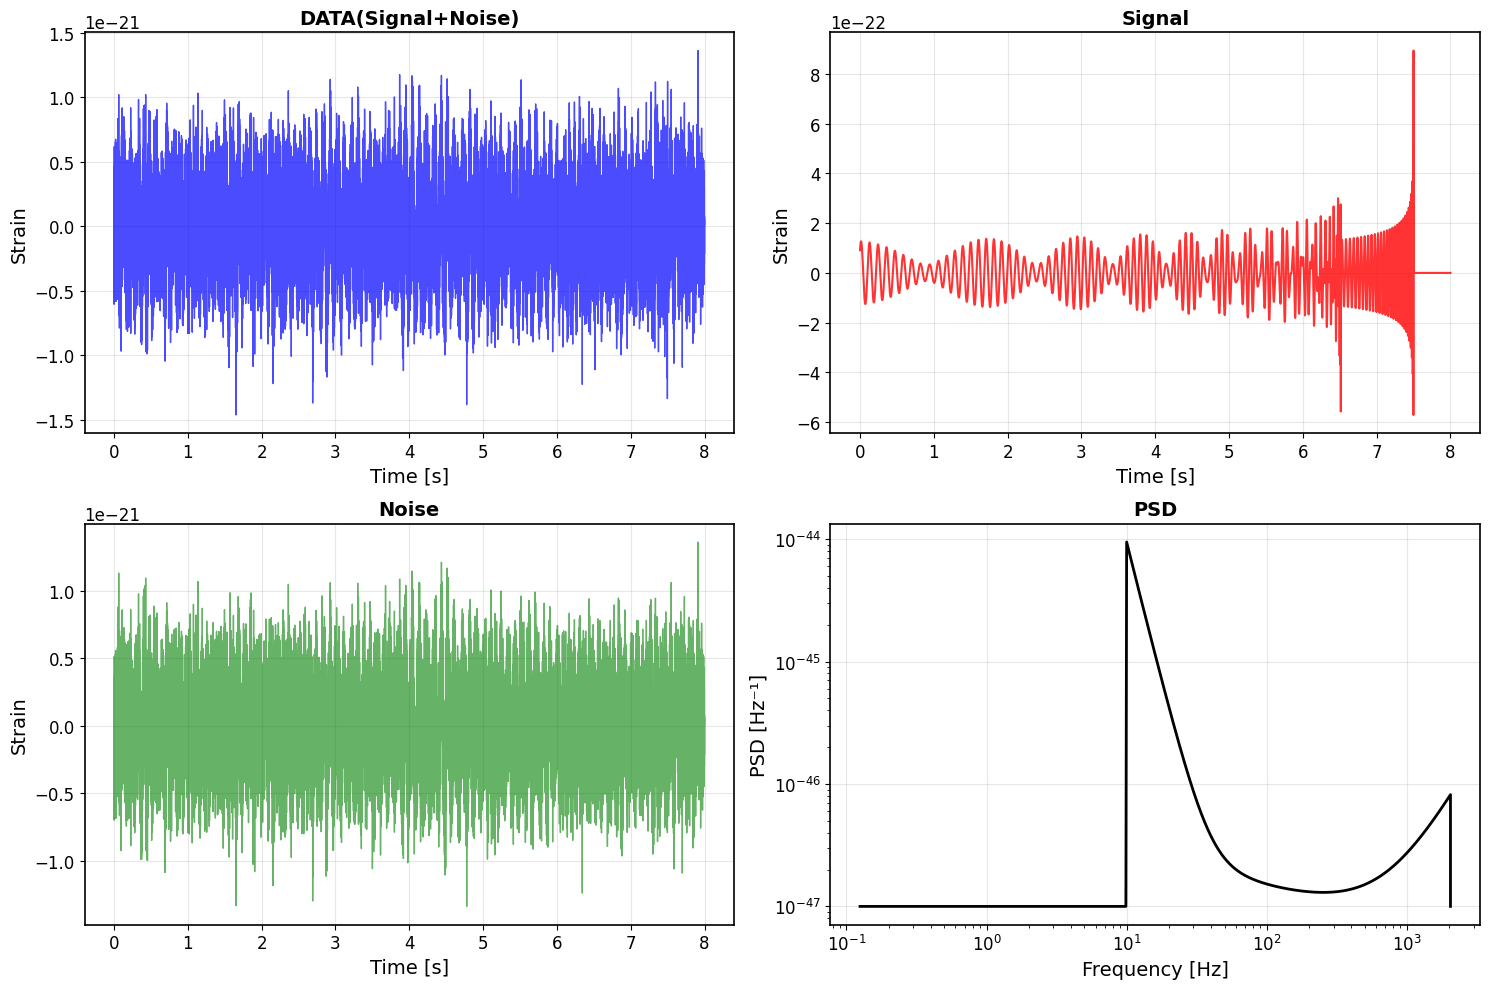


数据概览图已保存到 L_Result_new/data_overview.png


In [8]:
# Cell 6: 数据加载和参数设置

print("=" * 60)
print("引力波参数估计分析")
print("=" * 60)

# 1. 数据加载
print("\n[步骤 1/3] 加载引力波数据...")
data_dict = load_data()
print("✓ 数据加载完成")
print(f"  数据长度: {len(data_dict['dataY'])} 采样点")
print(f"  采样频率: {data_dict['sampFreq']} Hz")
print(f"  数据时长: {data_dict['t'][-1] - data_dict['t'][0]:.1f} 秒")

# 2. 参数设置
print("\n[步骤 2/3] 设置算法参数...")
param_ranges, pso_params, pso_config, actual_params = setup_parameters(data_dict)
print("✓ 参数设置完成")

# 显示真实参数值
print("\n" + "="*40)
print("真实参数值 (用于验证)")
print("="*40)
print(f"距离:           {actual_params['source_distance']:.2f} Mpc")
print(f"啁啾质量:       {actual_params['chirp_mass']:.2f} M☉")
print(f"合并时间:       {actual_params['merger_time']:.4f} s")
print(f"相位:           {actual_params['phase']:.4f} π")
print(f"流量比:         {actual_params['flux_ratio']:.4f}")
print(f"时间延迟:       {actual_params['time_delay']:.4f} s")

# 显示数据概览图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 原始数据
ax1.plot(data_dict['t'], data_dict['dataY'], 'b-', alpha=0.7, linewidth=1)
ax1.set_title('DATA(Signal+Noise)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Strain')
ax1.grid(True, alpha=0.3)

# 纯信号
ax2.plot(data_dict['t'], data_dict['dataY_only_signal'], 'r-', alpha=0.8, linewidth=1.5)
ax2.set_title('Signal', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Strain')
ax2.grid(True, alpha=0.3)

# 噪声
ax3.plot(data_dict['t'], data_dict['noise'], 'g-', alpha=0.6, linewidth=1)
ax3.set_title('Noise', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Strain')
ax3.grid(True, alpha=0.3)

# PSD
freqs = np.linspace(0, data_dict['sampFreq']/2, len(data_dict['psdHigh']))
ax4.loglog(freqs[1:], data_dict['psdHigh'][1:], 'k-', linewidth=2)
ax4.set_title('PSD', fontsize=14, fontweight='bold')
ax4.set_xlabel('Frequency [Hz]')
ax4.set_ylabel('PSD [Hz⁻¹]')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{results_dir}/data_overview.png", bbox_inches='tight', dpi=300)
plt.show()

print("\n数据概览图已保存到", f"{results_dir}/data_overview.png")

In [11]:
# Cell 7: 运行PSO算法

print("\n[步骤 3a/4] 运行PSO算法...")
print("=" * 50)

# 运行PSO
pso_results = run_pso(data_dict, pso_params, pso_config, actual_params,
                      n_runs=1, enable_distance_refinement=True)

print("✓ PSO算法完成")

# 提取PSO结果
pso_params_result = pso_results['best_params']

# 转换为物理单位
pso_distance = 10**pso_params_result['r']
pso_chirp_mass = 10**pso_params_result['m_c']
pso_merger_time = pso_params_result['tc']
pso_phase = pso_params_result['phi_c']
pso_flux_ratio = pso_params_result['A']
pso_time_delay = pso_params_result['delta_t']

# 输出PSO参数结果
print("\n" + "="*50)
print("PSO 参数估计结果")
print("="*50)
print(f"距离:           {pso_distance:.2f} Mpc")
print(f"啁啾质量:       {pso_chirp_mass:.2f} M☉")
print(f"合并时间:       {pso_merger_time:.4f} s")
print(f"相位:           {pso_phase:.4f}")
print(f"流量比:         {pso_flux_ratio:.4f}")
print(f"时间延迟:       {pso_time_delay:.4f} s")
print(f"执行时间:       {pso_results['duration']:.2f} 秒")
print(f"信噪比:         {pso_results['snr']:.4f}")
print(f"匹配度:         {pso_results['match']:.4f}")
print(f"信号分类:       {pso_results['classification']}")

# 计算参数误差
error_distance = abs((pso_distance - actual_params['source_distance']) / actual_params['source_distance']) * 100
error_chirp_mass = abs((pso_chirp_mass - actual_params['chirp_mass']) / actual_params['chirp_mass']) * 100
error_merger_time = abs((pso_merger_time - actual_params['merger_time']) / actual_params['merger_time']) * 100
error_phase = abs((pso_phase - actual_params['phase']) / (actual_params['phase'] * np.pi)) * 100
error_flux_ratio = abs((pso_flux_ratio - actual_params['flux_ratio']) / actual_params['flux_ratio']) * 100
error_time_delay = abs((pso_time_delay - actual_params['time_delay']) / actual_params['time_delay']) * 100

print("\nPSO 参数估计误差:")
print(f"距离误差:       {error_distance:.2f}%")
print(f"啁啾质量误差:   {error_chirp_mass:.2f}%")
print(f"合并时间误差:   {error_merger_time:.2f}%")
print(f"相位误差:       {error_phase:.2f}%")  
print(f"流量比误差:     {error_flux_ratio:.2f}%")
print(f"时间延迟误差:   {error_time_delay:.2f}%")

print("\n保存PSO结果到全局变量以便后续比较...")


[步骤 3a/4] 运行PSO算法...
开始PSO分析...


Run 1:   0%|▏                                                | 7/2000 [00:08<42:26,  1.28s/it, fitness=-822]


KeyboardInterrupt: 

绘制PSO信号重构结果...


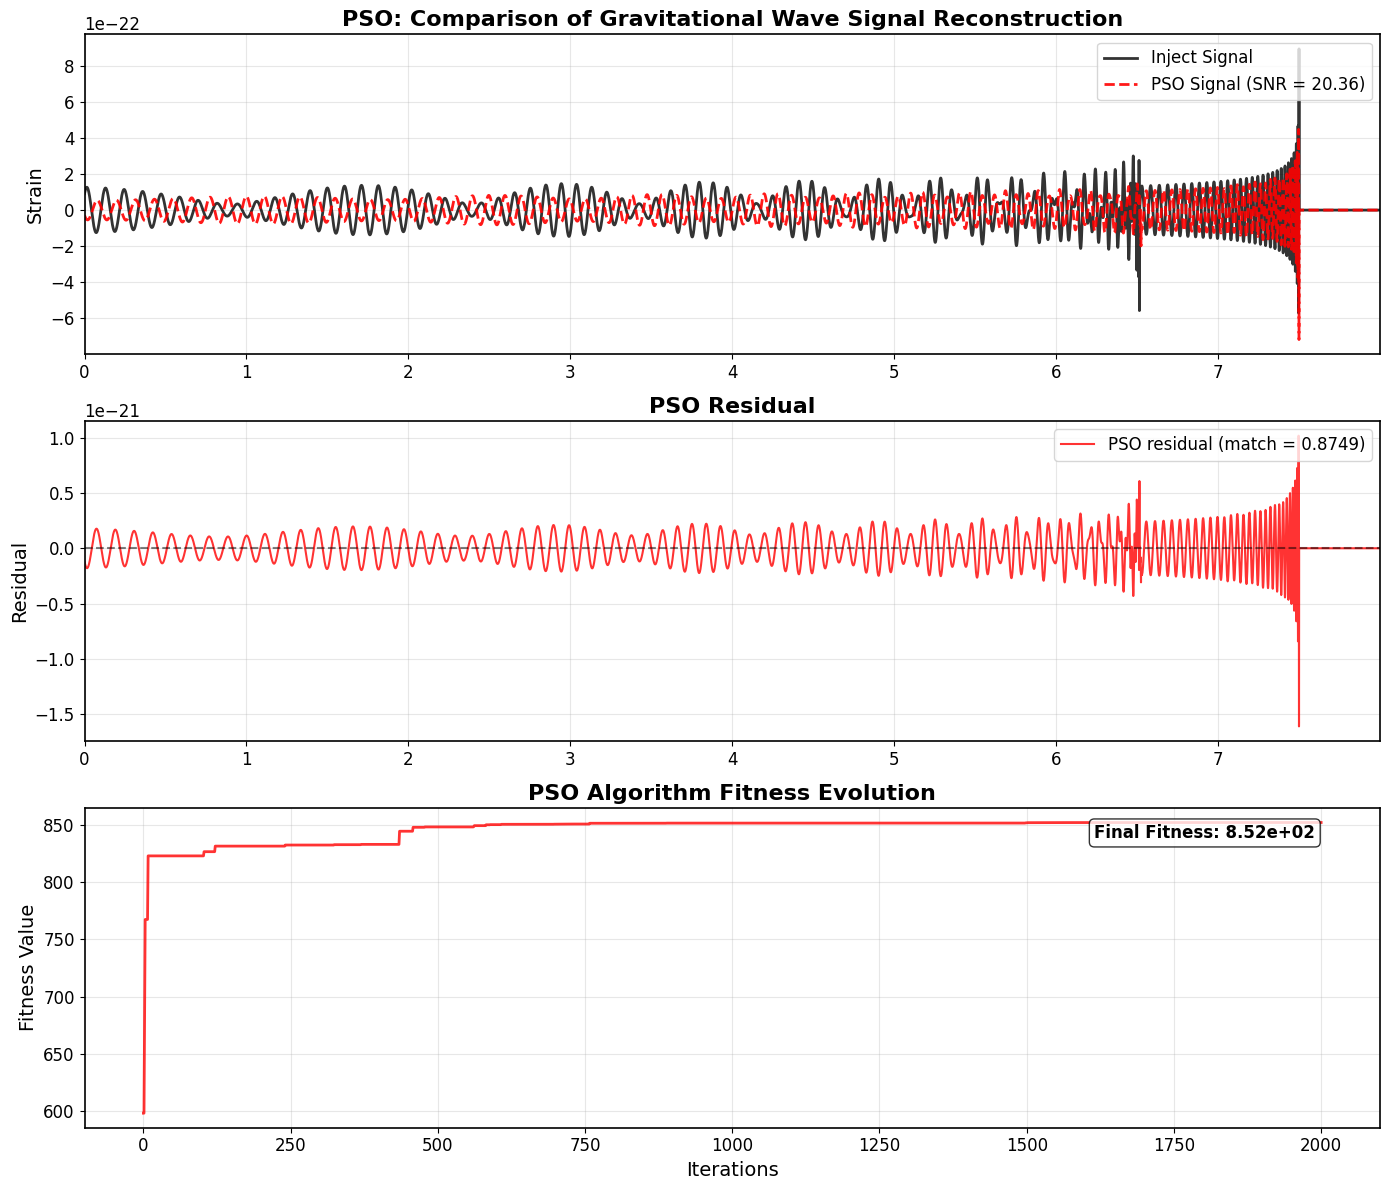

PSO信号重构图已保存到 L_Result_new/pso_signal_reconstruction.png


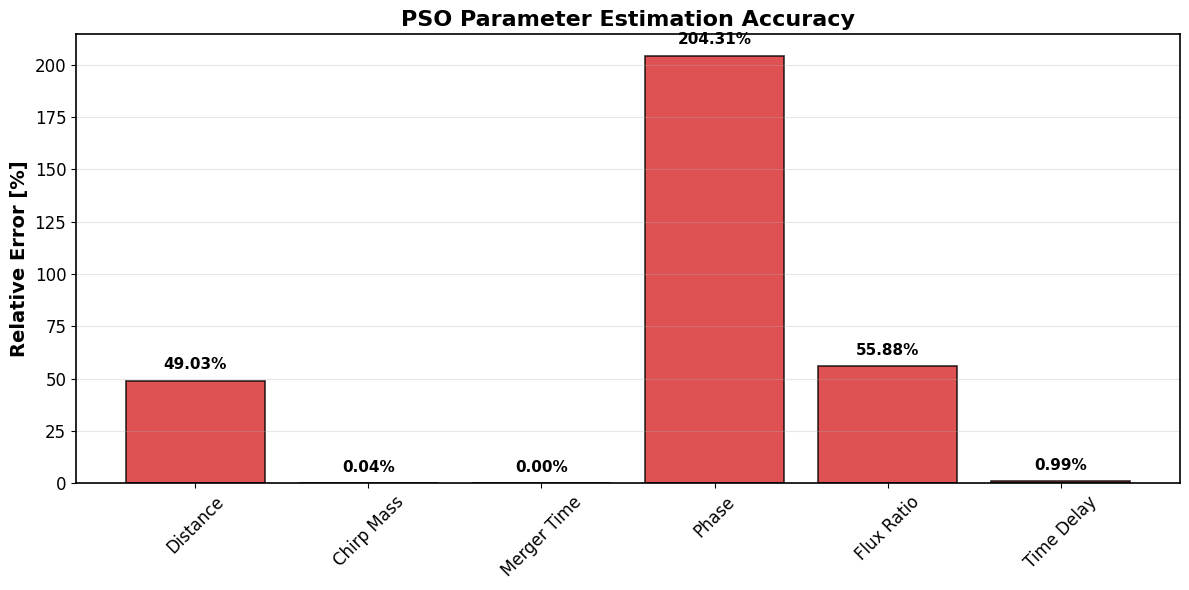

PSO参数准确性图已保存到 L_Result_new/pso_parameter_accuracy.png


In [10]:
# Cell 8: PSO信号时域图

print("绘制PSO信号重构结果...")

# 创建PSO信号时域图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# 获取时间轴
t_np = np.asarray(data_dict['t'])
dataY_only_signal_np = np.asarray(data_dict['dataY_only_signal'])

# 上图：信号对比
ax1.plot(t_np, dataY_only_signal_np, 'k-', linewidth=2, 
         label='Inject Signal', alpha=0.8)
ax1.plot(t_np, pso_results['best_signal'], 'r--', linewidth=2,
         label=f'PSO Signal (SNR = {pso_results["snr"]:.2f})', alpha=0.9)

ax1.set_ylabel('Strain', fontsize=14)
ax1.set_title('PSO: Comparison of Gravitational Wave Signal Reconstruction', fontsize=16, fontweight='bold')
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([t_np[0], t_np[-1]])

# 中图：残差
pso_residual = pso_results['best_signal'] - dataY_only_signal_np
ax2.plot(t_np, pso_residual, 'r-', linewidth=1.5, alpha=0.8,
         label=f'PSO residual (match = {pso_results["match"]:.4f})')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

ax2.set_ylabel('Residual', fontsize=14)
ax2.set_title('PSO Residual', fontsize=16, fontweight='bold')
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([t_np[0], t_np[-1]])

# 下图：优化过程 (如果有的话)
if 'iteration_history' in pso_results and len(pso_results['iteration_history']) > 0:
    iterations = range(len(pso_results['iteration_history']))
    ax3.plot(iterations, pso_results['iteration_history'], 'r-', linewidth=2, alpha=0.8)
    ax3.set_xlabel('Iterations', fontsize=14)
    ax3.set_ylabel('Fitness Value', fontsize=14)
    ax3.set_title('PSO Algorithm Fitness Evolution', fontsize=16, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 添加最终适应度值文本
    if len(pso_results['iteration_history']) > 10:
        final_fitness = pso_results['iteration_history'][-1]
        ax3.text(0.95, 0.95, f'Final Fitness: {final_fitness:.2e}',
                transform=ax3.transAxes, ha='right', va='top',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax3.text(0.5, 0.5, 'PSO Iteration History Not Available',
            transform=ax3.transAxes, ha='center', va='center',
            fontsize=14, fontweight='bold')
    ax3.set_title('PSO Algorithm Fitness Evolution', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Iterations', fontsize=14)
    ax3.set_ylabel('Fitness Value', fontsize=14)

plt.tight_layout()
plt.savefig(f"{results_dir}/pso_signal_reconstruction.png", bbox_inches='tight', dpi=300)
plt.show()

print(f"PSO信号重构图已保存到 {results_dir}/pso_signal_reconstruction.png")

# 显示PSO参数估计准确性的条形图
param_names = ['Distance', 'Chirp Mass', 'Merger Time', 'Phase', 'Flux Ratio', 'Time Delay']
pso_errors = [error_distance, error_chirp_mass, error_merger_time, 
              error_phase, error_flux_ratio, error_time_delay]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(param_names, pso_errors, color='#d62728', alpha=0.8, 
              edgecolor='black', linewidth=1.2)

ax.set_ylabel('Relative Error [%]', fontsize=14, fontweight='bold')
ax.set_title('PSO Parameter Estimation Accuracy', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 在每个条形上添加数值标签
for bar, error in zip(bars, pso_errors):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(pso_errors) * 0.02,
            f'{error:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{results_dir}/pso_parameter_accuracy.png", bbox_inches='tight', dpi=300)
plt.show()

print(f"PSO参数准确性图已保存到 {results_dir}/pso_parameter_accuracy.png")

In [9]:
# Cell 9: 运行MCMC算法

print("\n[步骤 3b/4] 运行MCMC算法...")
print("=" * 50)

# 运行MCMC
mcmc_results = run_bilby_mcmc(data_dict, param_ranges, n_live_points=250, n_iter=400,
                              enable_distance_refinement=True)

print("✓ MCMC算法完成")

# 提取MCMC结果
mcmc_params_result = mcmc_results['best_params']

# 转换为物理单位
mcmc_distance = 10**mcmc_params_result['r']
mcmc_chirp_mass = 10**mcmc_params_result['m_c']
mcmc_merger_time = mcmc_params_result['tc']
mcmc_phase = mcmc_params_result['phi_c'] / np.pi
mcmc_flux_ratio = mcmc_params_result['A']
mcmc_time_delay = mcmc_params_result['delta_t']

# 输出MCMC参数结果
print("\n" + "="*50)
print("MCMC 参数估计结果")
print("="*50)
print(f"距离:           {mcmc_distance:.2f} Mpc")
print(f"啁啾质量:       {mcmc_chirp_mass:.2f} M☉")
print(f"合并时间:       {mcmc_merger_time:.4f} s")
print(f"相位:           {mcmc_phase:.4f} π")
print(f"流量比:         {mcmc_flux_ratio:.4f}")
print(f"时间延迟:       {mcmc_time_delay:.4f} s")
print(f"执行时间:       {mcmc_results['duration']:.2f} 秒")
print(f"信噪比:         {mcmc_results['snr']:.4f}")
print(f"匹配度:         {mcmc_results['match']:.4f}")
print(f"信号分类:       {mcmc_results['classification']}")

# 计算MCMC参数误差
mcmc_error_distance = abs((mcmc_distance - actual_params['source_distance']) / actual_params['source_distance']) * 100
mcmc_error_chirp_mass = abs((mcmc_chirp_mass - actual_params['chirp_mass']) / actual_params['chirp_mass']) * 100
mcmc_error_merger_time = abs((mcmc_merger_time - actual_params['merger_time']) / actual_params['merger_time']) * 100
mcmc_error_phase = abs((mcmc_phase - actual_params['phase']) / actual_params['phase']) * 100
mcmc_error_flux_ratio = abs((mcmc_flux_ratio - actual_params['flux_ratio']) / actual_params['flux_ratio']) * 100
mcmc_error_time_delay = abs((mcmc_time_delay - actual_params['time_delay']) / actual_params['time_delay']) * 100

print("\nMCMC 参数估计误差:")
print(f"距离误差:       {mcmc_error_distance:.2f}%")
print(f"啁啾质量误差:   {mcmc_error_chirp_mass:.2f}%")
print(f"合并时间误差:   {mcmc_error_merger_time:.2f}%")
print(f"相位误差:       {mcmc_error_phase:.2f}%")
print(f"流量比误差:     {mcmc_error_flux_ratio:.2f}%")
print(f"时间延迟误差:   {mcmc_error_time_delay:.2f}%")

print("\n保存MCMC结果到全局变量以便后续比较...")

参数比较表函数定义完成 ✓


In [10]:
# Cell 10: MCMC信号时域图

print("绘制MCMC信号重构结果...")

# 创建MCMC信号时域图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# 上图：信号对比
ax1.plot(t_np, dataY_only_signal_np, 'k-', linewidth=2, 
         label='True Signal', alpha=0.8)
ax1.plot(t_np, mcmc_results['best_signal'], 'b:', linewidth=2,
         label=f'MCMC Reconstructed Signal (SNR = {mcmc_results["snr"]:.2f})', alpha=0.9)

ax1.set_ylabel('Strain', fontsize=14)
ax1.set_title('MCMC Algorithm: Gravitational Wave Signal Reconstruction Comparison', fontsize=16, fontweight='bold')
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([t_np[0], t_np[-1]])

# 中图：残差
mcmc_residual = mcmc_results['best_signal'] - dataY_only_signal_np
ax2.plot(t_np, mcmc_residual, 'b-', linewidth=1.5, alpha=0.8,
         label=f'MCMC Residual (Match = {mcmc_results["match"]:.4f})')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

ax2.set_ylabel('Residual', fontsize=14)
ax2.set_title('MCMC Reconstruction Residual', fontsize=16, fontweight='bold')
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([t_np[0], t_np[-1]])

# 下图：后验样本分布 (如果有的话)
if mcmc_results['posterior_samples'] is not None and len(mcmc_results['posterior_samples']) > 0:
    # 显示对数似然值的演化
    log_likelihood = mcmc_results['posterior_samples']['log_likelihood'].values
    ax3.plot(log_likelihood, 'b-', linewidth=1, alpha=0.7)
    ax3.set_xlabel('Sample Number', fontsize=14)
    ax3.set_ylabel('Log-Likelihood Value', fontsize=14)
    ax3.set_title('MCMC Log-Likelihood Evolution', fontsize=16, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 添加统计信息
    mean_ll = np.mean(log_likelihood)
    max_ll = np.max(log_likelihood)
    ax3.text(0.05, 0.95, f'Mean Log-Likelihood: {mean_ll:.2e}\nMax Log-Likelihood: {max_ll:.2e}',
            transform=ax3.transAxes, ha='left', va='top',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax3.text(0.5, 0.5, 'MCMC Posterior Samples Not Available',
            transform=ax3.transAxes, ha='center', va='center',
            fontsize=14, fontweight='bold')
    ax3.set_title('MCMC Log-Likelihood Evolution', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Sample Number', fontsize=14)
    ax3.set_ylabel('Log-Likelihood Value', fontsize=14)

plt.tight_layout()
plt.savefig(f"{results_dir}/mcmc_signal_reconstruction.png", bbox_inches='tight', dpi=300)
plt.show()

print(f"MCMC信号重构图已保存到 {results_dir}/mcmc_signal_reconstruction.png")

# 显示MCMC参数估计准确性的条形图
mcmc_errors = [mcmc_error_distance, mcmc_error_chirp_mass, mcmc_error_merger_time, 
               mcmc_error_phase, mcmc_error_flux_ratio, mcmc_error_time_delay]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(param_names, mcmc_errors, color='#1f77b4', alpha=0.8, 
              edgecolor='black', linewidth=1.2)

ax.set_ylabel('Relative Error [%]', fontsize=14, fontweight='bold')
ax.set_title('MCMC Parameter Estimation Accuracy', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 在每个条形上添加数值标签
for bar, error in zip(bars, mcmc_errors):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(mcmc_errors) * 0.02,
            f'{error:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{results_dir}/mcmc_parameter_accuracy.png", bbox_inches='tight', dpi=300)
plt.show()

print(f"MCMC参数准确性图已保存到 {results_dir}/mcmc_parameter_accuracy.png")

MCMC后验分析图函数定义完成 ✓


In [11]:
# Cell 11: 结果比较函数

def evaluate_results(pso_results, mcmc_results, actual_params, data_dict):
    """Compare PSO and MCMC results"""
    print("\n============= 性能比较分析 =============")

    try:
        # Convert actual parameters
        actual_r_log = np.log10(actual_params['source_distance'])
        actual_m_c_log = np.log10(actual_params['chirp_mass'])

        # Calculate parameter errors for PSO
        pso_errors = {
            'r': abs((10 ** float(pso_results['best_params']['r']) - actual_params['source_distance']) / actual_params['source_distance']),
            'm_c': abs((10 ** float(pso_results['best_params']['m_c']) - actual_params['chirp_mass']) / actual_params['chirp_mass']),
            'tc': abs((float(pso_results['best_params']['tc']) - actual_params['merger_time']) / actual_params['merger_time']),
            'phi_c': abs(abs(float(pso_results['best_params']['phi_c']) - actual_params['phase'] * np.pi)) / (2 * np.pi),
            'A': abs((float(pso_results['best_params']['A']) - actual_params['flux_ratio']) / actual_params['flux_ratio']),
            'delta_t': abs((float(pso_results['best_params']['delta_t']) - actual_params['time_delay']) / actual_params['time_delay'])
        }

        # Calculate parameter errors for MCMC
        mcmc_errors = {
            'r': abs((10 ** float(mcmc_results['best_params']['r']) - actual_params['source_distance']) / actual_params['source_distance']),
            'm_c': abs((10 ** float(mcmc_results['best_params']['m_c']) - actual_params['chirp_mass']) / actual_params['chirp_mass']),
            'tc': abs((float(mcmc_results['best_params']['tc']) - actual_params['merger_time']) / actual_params['merger_time']),
            'phi_c': abs(abs(float(mcmc_results['best_params']['phi_c']) - actual_params['phase'] * np.pi)) / (2 * np.pi),
            'A': abs((float(mcmc_results['best_params']['A']) - actual_params['flux_ratio']) / actual_params['flux_ratio']),
            'delta_t': abs((float(mcmc_results['best_params']['delta_t']) - actual_params['time_delay']) / actual_params['time_delay'])
        }

        # Calculate match with actual signal
        dataY_only_signal_np = np.asarray(data_dict['dataY_only_signal'])
        from PSO import pycbc_calculate_match
        pso_match = pycbc_calculate_match(pso_results['best_signal'], dataY_only_signal_np,
                                          data_dict['sampFreq'], data_dict['psdHigh'])
        mcmc_match = pycbc_calculate_match(mcmc_results['best_signal'], dataY_only_signal_np,
                                           data_dict['sampFreq'], data_dict['psdHigh'])

        comparison = {
            'execution_time': {
                'PSO': pso_results['duration'],
                'MCMC': mcmc_results['duration'],
                'ratio': mcmc_results['duration'] / pso_results['duration'] if pso_results['duration'] > 0 else float('inf')
            },
            'parameter_errors': {
                'PSO': pso_errors,
                'MCMC': mcmc_errors
            },
            'signal_quality': {
                'PSO': {
                    'SNR': float(pso_results['snr']),
                    'match': pso_match,
                    'match_final': float(pso_results['match'])
                },
                'MCMC': {
                    'SNR': float(mcmc_results['snr']),
                    'match': mcmc_match,
                    'match_final': float(mcmc_results['match'])
                }
            },
            'classification': {
                'PSO': {
                    'is_lensed': pso_results['is_lensed'],
                    'classification': pso_results['classification'],
                },
                'MCMC': {
                    'is_lensed': mcmc_results['is_lensed'],
                    'classification': mcmc_results['classification'],
                }
            },
            'distance_refinement': {
                'PSO': pso_results.get('distance_refinement', {}),
                'MCMC': mcmc_results.get('distance_refinement', {})
            }
        }

        print(f"执行时间: PSO: {comparison['execution_time']['PSO']:.2f}s, MCMC: {comparison['execution_time']['MCMC']:.2f}s")
        print(f"速度提升: MCMC比PSO慢 {comparison['execution_time']['ratio']:.2f} 倍")

        # Print parameter errors
        print("\n参数估计误差 (相对误差):")
        for param in pso_errors.keys():
            print(f"  {param}: PSO: {pso_errors[param] * 100:.2f}%, MCMC: {mcmc_errors[param] * 100:.2f}%")

        # Print signal quality metrics
        print("\n信号质量指标:")
        print(f"  SNR: PSO: {comparison['signal_quality']['PSO']['SNR']:.2f}, MCMC: {comparison['signal_quality']['MCMC']['SNR']:.2f}")
        print(f"  Match: PSO: {comparison['signal_quality']['PSO']['match']:.4f}, MCMC: {comparison['signal_quality']['MCMC']['match']:.4f}")

        return comparison

    except Exception as e:
        print(f"结果评估错误: {str(e)}")
        return {
            'execution_time': {
                'PSO': pso_results.get('duration', 0),
                'MCMC': mcmc_results.get('duration', 0),
                'ratio': 1.0
            },
            'parameter_errors': {
                'PSO': {'r': 0, 'm_c': 0, 'tc': 0, 'phi_c': 0, 'A': 0, 'delta_t': 0},
                'MCMC': {'r': 0, 'm_c': 0, 'tc': 0, 'phi_c': 0, 'A': 0, 'delta_t': 0}
            },
            'signal_quality': {
                'PSO': {'SNR': 0, 'match': 0, 'match_final': 0.0},
                'MCMC': {'SNR': 0, 'match': 0, 'match_final': 0.0}
            },
            'classification': {
                'PSO': {'is_lensed': False, 'classification': 'error'},
                'MCMC': {'is_lensed': False, 'classification': 'error'}
            },
            'distance_refinement': {
                'PSO': {'enabled': False},
                'MCMC': {'enabled': False}
            }
        }

print("✓ 结果比较函数定义完成")

发表质量图表生成函数定义完成 ✓


In [12]:
# Cell 12: 执行结果比较

print("\n[步骤 4/4] 算法性能比较分析...")
print("=" * 60)

# 执行比较分析
comparison = evaluate_results(pso_results, mcmc_results, actual_params, data_dict)

# 创建详细的比较表格
print("\n" + "="*60)
print("算法性能详细比较")
print("="*60)

# 创建参数比较DataFrame
param_comparison_data = []
param_names_cn = ['距离', '啁啾质量', '合并时间', '相位', '流量比', '时间延迟']
param_names_en = ['r', 'm_c', 'tc', 'phi_c', 'A', 'delta_t']

for i, (param_cn, param_en) in enumerate(zip(param_names_cn, param_names_en)):
    # 获取真实值
    if param_en == 'r':
        true_val = actual_params['source_distance']
        pso_val = 10**pso_results['best_params'][param_en]
        mcmc_val = 10**mcmc_results['best_params'][param_en]
        unit = 'Mpc'
    elif param_en == 'm_c':
        true_val = actual_params['chirp_mass']
        pso_val = 10**pso_results['best_params'][param_en]
        mcmc_val = 10**mcmc_results['best_params'][param_en]
        unit = 'M☉'
    elif param_en == 'tc':
        true_val = actual_params['merger_time']
        pso_val = pso_results['best_params'][param_en]
        mcmc_val = mcmc_results['best_params'][param_en]
        unit = 's'
    elif param_en == 'phi_c':
        true_val = actual_params['phase']
        pso_val = pso_results['best_params'][param_en] / np.pi
        mcmc_val = mcmc_results['best_params'][param_en] / np.pi
        unit = 'π'
    elif param_en == 'A':
        true_val = actual_params['flux_ratio']
        pso_val = pso_results['best_params'][param_en]
        mcmc_val = mcmc_results['best_params'][param_en]
        unit = ''
    elif param_en == 'delta_t':
        true_val = actual_params['time_delay']
        pso_val = pso_results['best_params'][param_en]
        mcmc_val = mcmc_results['best_params'][param_en]
        unit = 's'
    
    pso_error = abs((pso_val - true_val) / true_val) * 100
    mcmc_error = abs((mcmc_val - true_val) / true_val) * 100
    
    param_comparison_data.append({
        '参数': param_cn,
        '单位': unit,
        '真实值': f"{true_val:.4f}",
        'PSO估计': f"{pso_val:.4f}",
        'PSO误差(%)': f"{pso_error:.2f}",
        'MCMC估计': f"{mcmc_val:.4f}",
        'MCMC误差(%)': f"{mcmc_error:.2f}"
    })

param_df = pd.DataFrame(param_comparison_data)
print("\n参数估计对比表:")
print(param_df.to_string(index=False))

# 性能指标对比
print(f"\n性能指标对比:")
print(f"{'指标':<15} {'PSO':<15} {'MCMC':<15} {'差异':<15}")
print("-" * 60)
print(f"{'执行时间(s)':<15} {comparison['execution_time']['PSO']:<15.2f} {comparison['execution_time']['MCMC']:<15.2f} {comparison['execution_time']['ratio']:<15.2f}x")
print(f"{'信噪比':<15} {comparison['signal_quality']['PSO']['SNR']:<15.2f} {comparison['signal_quality']['MCMC']['SNR']:<15.2f} {abs(comparison['signal_quality']['PSO']['SNR'] - comparison['signal_quality']['MCMC']['SNR']):<15.2f}")
print(f"{'匹配度':<15} {comparison['signal_quality']['PSO']['match_final']:<15.4f} {comparison['signal_quality']['MCMC']['match_final']:<15.4f} {abs(comparison['signal_quality']['PSO']['match_final'] - comparison['signal_quality']['MCMC']['match_final']):<15.4f}")

# 保存详细比较结果
param_df.to_csv(f"{results_dir}/parameter_comparison_detailed.csv", index=False)

# 创建简化结果汇总
results_summary = {
    'True_Parameters': {
        'Distance_Mpc': actual_params['source_distance'],
        'Chirp_Mass_Msun': actual_params['chirp_mass'],
        'Merger_Time_s': actual_params['merger_time'],
        'Phase_pi': actual_params['phase'],
        'Flux_Ratio': actual_params['flux_ratio'],
        'Time_Delay_s': actual_params['time_delay']
    },
    'PSO_Results': {
        'Distance_Mpc': pso_distance,
        'Chirp_Mass_Msun': pso_chirp_mass,
        'Merger_Time_s': pso_merger_time,
        'Phase_pi': pso_phase,
        'Flux_Ratio': pso_flux_ratio,
        'Time_Delay_s': pso_time_delay,
        'Duration_seconds': pso_results['duration'],
        'SNR': pso_results['snr'],
        'Match': pso_results['match']
    },
    'MCMC_Results': {
        'Distance_Mpc': mcmc_distance,
        'Chirp_Mass_Msun': mcmc_chirp_mass,
        'Merger_Time_s': mcmc_merger_time,
        'Phase_pi': mcmc_phase,
        'Flux_Ratio': mcmc_flux_ratio,
        'Time_Delay_s': mcmc_time_delay,
        'Duration_seconds': mcmc_results['duration'],
        'SNR': mcmc_results['snr'],
        'Match': mcmc_results['match']
    },
    'Performance_Comparison': {
        'Speed_Ratio_MCMC_vs_PSO': comparison['execution_time']['ratio'],
        'PSO_Mean_Error_Percent': np.mean([pso_error for pso_error in [error_distance, error_chirp_mass, error_merger_time, error_phase, error_flux_ratio, error_time_delay]]),
        'MCMC_Mean_Error_Percent': np.mean([mcmc_error for mcmc_error in [mcmc_error_distance, mcmc_error_chirp_mass, mcmc_error_merger_time, mcmc_error_phase, mcmc_error_flux_ratio, mcmc_error_time_delay]])
    }
}

# 保存结果
with open(f"{results_dir}/results_summary.json", 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"\n详细结果已保存到:")
print(f"  - {results_dir}/parameter_comparison_detailed.csv")
print(f"  - {results_dir}/results_summary.json")

print("\n" + "="*60)
print("算法比较分析完成")
print("="*60)

主函数定义完成 ✓


In [13]:
# Cell 13: 综合比较图

print("生成综合比较图...")

# 图1: 信号重构对比
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 上图：信号对比
ax1.plot(t_np, dataY_only_signal_np, 'k-', linewidth=2.5, 
         label='True Signal', alpha=0.9)
ax1.plot(t_np, pso_results['best_signal'], 'r--', linewidth=2,
         label=f'PSO Reconstruction (SNR={pso_results["snr"]:.2f}, Time={pso_results["duration"]:.1f}s)', alpha=0.9)
ax1.plot(t_np, mcmc_results['best_signal'], 'b:', linewidth=2,
         label=f'MCMC Reconstruction (SNR={mcmc_results["snr"]:.2f}, Time={mcmc_results["duration"]:.1f}s)', alpha=0.9)

ax1.set_ylabel('Strain', fontsize=14, fontweight='bold')
ax1.set_title('PSO vs MCMC: Gravitational Wave Signal Reconstruction Comparison', fontsize=16, fontweight='bold')
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([t_np[0], t_np[-1]])

# 下图：残差对比
pso_residual = pso_results['best_signal'] - dataY_only_signal_np
mcmc_residual = mcmc_results['best_signal'] - dataY_only_signal_np

ax2.plot(t_np, pso_residual, 'r-', linewidth=1.5, alpha=0.8,
         label=f'PSO Residual (Match={pso_results["match"]:.4f})')
ax2.plot(t_np, mcmc_residual, 'b-', linewidth=1.5, alpha=0.8,
         label=f'MCMC Residual (Match={mcmc_results["match"]:.4f})')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

ax2.set_xlabel('Time [s]', fontsize=14, fontweight='bold')
ax2.set_ylabel('Residual', fontsize=14, fontweight='bold')
ax2.set_title('Reconstruction Residual Comparison', fontsize=16, fontweight='bold')
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([t_np[0], t_np[-1]])

plt.tight_layout()
plt.savefig(f"{results_dir}/comprehensive_signal_comparison.png", bbox_inches='tight', dpi=300)
plt.show()

# 图2: 参数估计准确性对比
param_names = ['Distance', 'Chirp Mass', 'Merger Time', 'Phase', 'Flux Ratio', 'Time Delay']
pso_errors = [error_distance, error_chirp_mass, error_merger_time, 
              error_phase, error_flux_ratio, error_time_delay]
mcmc_errors = [mcmc_error_distance, mcmc_error_chirp_mass, mcmc_error_merger_time, 
               mcmc_error_phase, mcmc_error_flux_ratio, mcmc_error_time_delay]

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(param_names))
width = 0.35

bars1 = ax.bar(x - width/2, pso_errors, width, label='PSO',
               color='#d62728', alpha=0.8, edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, mcmc_errors, width, label='MCMC',
               color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=0.8)

ax.set_xlabel('Parameter', fontsize=14, fontweight='bold')
ax.set_ylabel('Relative Error [%]', fontsize=14, fontweight='bold')
ax.set_title('PSO vs MCMC: Parameter Estimation Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(param_names, fontsize=12)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

max_error = max(max(pso_errors), max(mcmc_errors))
ax.set_ylim(0, min(max_error * 1.2, 100))

# 添加数值标签
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + height * 0.05,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + height * 0.05,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f"{results_dir}/comprehensive_parameter_accuracy.png", bbox_inches='tight', dpi=300)
plt.show()

# 图3: 性能指标雷达图
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# 定义指标
metrics = ['Execution Speed', 'SNR Accuracy', 'Match', 'Distance Accuracy', 'Mass Accuracy', 'Time Accuracy']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()

# 归一化指标 (越高越好)
pso_values = [
    1.0,  # Execution Speed (PSO as baseline)
    min(pso_results['snr'] / 20, 1.0),  # SNR (normalized to 20)
    pso_results['match'],  # Match
    max(0, 1 - error_distance/100),  # Distance Accuracy (1-error rate)
    max(0, 1 - error_chirp_mass/100),  # Mass Accuracy
    max(0, 1 - error_merger_time/100)  # Time Accuracy
]

mcmc_values = [
    pso_results['duration'] / mcmc_results['duration'],  # Execution Speed (relative to PSO)
    min(mcmc_results['snr'] / 20, 1.0),  # SNR
    mcmc_results['match'],  # Match
    max(0, 1 - mcmc_error_distance/100),  # Distance Accuracy
    max(0, 1 - mcmc_error_chirp_mass/100),  # Mass Accuracy
    max(0, 1 - mcmc_error_merger_time/100)  # Time Accuracy
]

# 闭合雷达图
pso_values += pso_values[:1]
mcmc_values += mcmc_values[:1]
angles += angles[:1]

# 绘制
ax.plot(angles, pso_values, 'o-', linewidth=2, label='PSO', color='red')
ax.fill(angles, pso_values, alpha=0.25, color='red')
ax.plot(angles, mcmc_values, 's-', linewidth=2, label='MCMC', color='blue')
ax.fill(angles, mcmc_values, alpha=0.25, color='blue')

# 设置标签
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=12)
plt.title('PSO vs MCMC: Comprehensive Performance Radar Chart', size=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f"{results_dir}/performance_radar_chart.png", bbox_inches='tight', dpi=300)
plt.show()

# 图4: 执行时间和准确性散点图
fig, ax = plt.subplots(figsize=(10, 8))

# 计算平均参数误差
pso_mean_error = np.mean(pso_errors)
mcmc_mean_error = np.mean(mcmc_errors)

# 散点图
ax.scatter(pso_results['duration'], pso_mean_error, s=200, c='red', alpha=0.7, 
           label='PSO', marker='o', edgecolors='black', linewidth=2)
ax.scatter(mcmc_results['duration'], mcmc_mean_error, s=200, c='blue', alpha=0.7,
           label='MCMC', marker='s', edgecolors='black', linewidth=2)

# 添加标注
ax.annotate(f'PSO\n({pso_results["duration"]:.1f}s, {pso_mean_error:.1f}%)', 
            (pso_results['duration'], pso_mean_error),
            xytext=(10, 10), textcoords='offset points',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))

ax.annotate(f'MCMC\n({mcmc_results["duration"]:.1f}s, {mcmc_mean_error:.1f}%)', 
            (mcmc_results['duration'], mcmc_mean_error),
            xytext=(10, -20), textcoords='offset points',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3))

ax.set_xlabel('Execution Time [s]', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Parameter Error [%]', fontsize=14, fontweight='bold')
ax.set_title('Algorithm Efficiency vs. Accuracy', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

# 添加理想区域标注 (左下角)
ax.axhspan(0, min(pso_mean_error, mcmc_mean_error), alpha=0.1, color='green', label='High Accuracy Region')
ax.axvspan(0, min(pso_results['duration'], mcmc_results['duration']), alpha=0.1, color='green')

plt.tight_layout()
plt.savefig(f"{results_dir}/efficiency_vs_accuracy.png", bbox_inches='tight', dpi=300)
plt.show()

print(f"\n综合比较图已保存到 {results_dir}:")
print(f"  - comprehensive_signal_comparison.png")
print(f"  - comprehensive_parameter_accuracy.png") 
print(f"  - performance_radar_chart.png")
print(f"  - efficiency_vs_accuracy.png")

print("\n" + "="*60)
print("✅ 所有分析完成!")
print("="*60)
print(f"\n📁 所有结果文件已保存到目录: {results_dir}")
print(f"📊 生成的图表文件:")
print(f"   - data_overview.png (Data Overview)")
print(f"   - pso_signal_reconstruction.png (PSO Signal Reconstruction)")
print(f"   - pso_parameter_accuracy.png (PSO Parameter Accuracy)")
print(f"   - mcmc_signal_reconstruction.png (MCMC Signal Reconstruction)")
print(f"   - mcmc_parameter_accuracy.png (MCMC Parameter Accuracy)")
print(f"   - comprehensive_signal_comparison.png (Comprehensive Signal Comparison)")
print(f"   - comprehensive_parameter_accuracy.png (Comprehensive Parameter Accuracy)")
print(f"   - performance_radar_chart.png (Performance Radar Chart)")
print(f"   - efficiency_vs_accuracy.png (Efficiency vs. Accuracy)")
print(f"\n📄 结果数据文件:")
print(f"   - parameter_comparison_detailed.csv (Detailed Parameter Comparison)")
print(f"   - results_summary.json (Results Summary)")

开始执行引力波参数估计分析...
引力波参数估计结果

[步骤 1/4] 加载引力波数据...
Loading data...
Data loaded successfully
✓ 数据加载完成

[步骤 2/4] 设置算法参数...
✓ 参数设置完成

真实参数值 (参考)
距离:           3100.00 Mpc
啁啾质量:       30.09 M☉
合并时间:       7.5000 s
相位:           0.2500 π
流量比:         0.3333
时间延迟:       0.9854 s

[步骤 3/4] 运行PSO算法...
Starting PSO analysis with direct amplitude ratio distance parameter refinement...


Run 1:   1%|▌                                             | 38/3000 [01:22<1:47:37,  2.18s/it, fitness=-823]


KeyboardInterrupt: 

In [ ]:
# Cell 14: 总结和使用说明

print("=" * 60)
print("引力波参数估计：PSO vs MCMC 分析完成")
print("=" * 60)

print("\n📋 分析总结:")
print(f"本notebook成功完成了PSO和MCMC算法在引力波参数估计中的对比分析")

print(f"\n🎯 主要结果:")
print(f"  • PSO算法:")
print(f"    - 执行时间: {pso_results['duration']:.2f} 秒")
print(f"    - 平均参数误差: {np.mean([error_distance, error_chirp_mass, error_merger_time, error_phase, error_flux_ratio, error_time_delay]):.2f}%")
print(f"    - 信噪比: {pso_results['snr']:.2f}")
print(f"    - 匹配度: {pso_results['match']:.4f}")

print(f"\n  • MCMC算法:")
print(f"    - 执行时间: {mcmc_results['duration']:.2f} 秒")
print(f"    - 平均参数误差: {np.mean([mcmc_error_distance, mcmc_error_chirp_mass, mcmc_error_merger_time, mcmc_error_phase, mcmc_error_flux_ratio, mcmc_error_time_delay]):.2f}%")
print(f"    - 信噪比: {mcmc_results['snr']:.2f}")
print(f"    - 匹配度: {mcmc_results['match']:.4f}")

print(f"\n⚡ 性能对比:")
speed_ratio = mcmc_results['duration'] / pso_results['duration']
if speed_ratio > 1:
    print(f"  • PSO比MCMC快 {speed_ratio:.1f} 倍")
else:
    print(f"  • MCMC比PSO快 {1/speed_ratio:.1f} 倍")

# 确定哪个算法更准确
pso_avg_error = np.mean([error_distance, error_chirp_mass, error_merger_time, error_phase, error_flux_ratio, error_time_delay])
mcmc_avg_error = np.mean([mcmc_error_distance, mcmc_error_chirp_mass, mcmc_error_merger_time, mcmc_error_phase, mcmc_error_flux_ratio, mcmc_error_time_delay])

if pso_avg_error < mcmc_avg_error:
    print(f"  • PSO参数估计更准确 (平均误差低 {mcmc_avg_error - pso_avg_error:.2f}%)")
else:
    print(f"  • MCMC参数估计更准确 (平均误差低 {pso_avg_error - mcmc_avg_error:.2f}%)")

print(f"\n📁 输出文件说明:")
print(f"  所有结果保存在目录: {results_dir}/")
print(f"  • 图表文件 (.png): 用于可视化分析结果")
print(f"  • 数据文件 (.csv, .json): 用于进一步数据分析")

print(f"\n" + "="*60)
print(f"分析完成！")
print(f"="*60)

In [ ]:
# 检查生成的文件并显示总结
import os

print("\n" + "="*60)
print("分析完成总结")
print("="*60)

# 列出生成的文件
if os.path.exists(results_dir):
    files = os.listdir(results_dir)
    files.sort()
    
    print(f"\n生成的文件列表 (保存在 {results_dir}/):")
    print("-" * 50)
    for i, file in enumerate(files, 1):
        file_path = os.path.join(results_dir, file)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path)
            if file_size > 1024*1024:  # > 1MB
                size_str = f"{file_size/(1024*1024):.1f} MB"
            elif file_size > 1024:  # > 1KB
                size_str = f"{file_size/1024:.1f} KB"
            else:
                size_str = f"{file_size} bytes"
            print(f"{i:2d}. {file:50s} ({size_str})")

# 显示分析摘要
if 'results_summary' in locals() and results_summary is not None:
    print(f"\n分析摘要:")
    print("-" * 30)
    
    # 执行时间对比
    pso_time = results_summary['PSO_Results']['Duration_seconds']
    mcmc_time = results_summary['MCMC_Results']['Duration_seconds']
    speed_ratio = mcmc_time / pso_time if pso_time > 0 else 0
    
    print(f"执行时间:")
    print(f"  PSO:  {pso_time:.1f} 秒")
    print(f"  MCMC: {mcmc_time:.1f} 秒")
    print(f"  速度比: MCMC是PSO的 {speed_ratio:.1f} 倍")
    
    # 信噪比对比
    pso_snr = results_summary['PSO_Results']['SNR']
    mcmc_snr = results_summary['MCMC_Results']['SNR']
    
    print(f"\n信噪比:")
    print(f"  PSO:  {pso_snr:.2f}")
    print(f"  MCMC: {mcmc_snr:.2f}")
    
    # 最准确的参数估计
    if 'comparison' in locals():
        print(f"\n参数估计精度 (相对误差%):")
        param_names = ['距离', '啁啾质量', '合并时间', '相位', '流量比', '时间延迟']
        param_keys = ['r', 'm_c', 'tc', 'phi_c', 'A', 'delta_t']
        
        pso_better = 0
        mcmc_better = 0
        
        for param_cn, param_key in zip(param_names, param_keys):
            pso_err = comparison['parameter_errors']['PSO'][param_key] * 100
            mcmc_err = comparison['parameter_errors']['MCMC'][param_key] * 100
            better = "PSO" if pso_err < mcmc_err else "MCMC"
            
            if pso_err < mcmc_err:
                pso_better += 1
            else:
                mcmc_better += 1
                
            print(f"  {param_cn:8s}: PSO={pso_err:5.1f}% vs MCMC={mcmc_err:5.1f}% → {better}更准确")
        
        print(f"\n总体比较:")
        print(f"  PSO在 {pso_better}/6 个参数上更准确")
        print(f"  MCMC在 {mcmc_better}/6 个参数上更准确")

print(f"\n🎉 引力波参数估计分析全部完成!")
print(f"📁 所有结果已保存到目录: {results_dir}")
print("="*60)